# exp001

In [2]:
import os
import sys
import gc
sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import itertools
from tqdm import tqdm
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import multiprocessing
import Levenshtein
import difflib
import pickle

In [3]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [4]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = 'exp001'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

In [5]:
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5
MODE = 'train'
TARGET = 'point_of_interest'
# MODE = 'inference'

In [6]:
# データ読み込み
train_origin = pd.read_csv(INPUT_DIR + "train.csv")
test_origin = pd.read_csv(INPUT_DIR + "test.csv")

In [10]:
# trainデータの分割
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin[TARGET], train_origin[TARGET])):
    train_origin.loc[val_idx, "set"] = i
train_origin["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [11]:
# candidate抽出
def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    candidates = pd.DataFrame()
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)

        targets = country_df[TARGET].values
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        dfs.append(country_df[['id','match_id','d_near']])
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train_origin[train_origin["set"]==0]), 
    add_neighbor_features(train_origin[train_origin["set"]==1]), 
])

/tmp/ipykernel_1107/1392210634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(str).str.lower()
100%|██████████| 210/210 [00:53<00:00,  3.91it/s]
/tmp/ipykernel_1107/1392210634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(str).str.lower()
100%|██████████| 211/211 [00:55<00:00,  3.81it/s]


In [12]:
train = train.explode(['match_id','d_near'])
train = train.loc[train['id'] != train['match_id']].copy()
train = train.merge(train_origin, on='id')
train = train.merge(train_origin.add_prefix('match_'), on='match_id')

In [13]:
# create target
train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)

In [14]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

id2poi = get_id2poi(train_origin)
poi2ids = get_poi2ids(train_origin)

In [15]:
scores = []

train_candidate = pd.DataFrame()
train_candidate['id'] = train_origin['id'].unique()
train_candidate['matches'] = train_origin['id'].unique()
idx = train[TARGET]==train["match_" + TARGET]
train_match = train.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
train_match.columns = ['id','candidates']
train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
idx = ~train_candidate['candidates'].isna()
train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
scores.append(get_score(train_candidate))
print(scores)


[0.8903997243526551]


In [16]:
%load_ext Cython

In [17]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [18]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_lcs"] = lcss
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train = add_distance_features(train)
#test = add_distance_features(test)

212it [13:47,  3.90s/it] 


In [19]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append("d_near")
for c in columns:        
    features += [f"match_{c}_gesh", f"match_{c}_jaro", f"match_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"match_{c}_leven"]
    else:
        features += [f"match_{c}_len", f"match_{c}_nleven", f"match_{c}_nlcsi"]

for f in features:
    assert f in train.columns
    #if f not in test.columns:
    #    test[f] = np.nan

print(features)

['d_near', 'match_name_gesh', 'match_name_jaro', 'match_name_lcs', 'match_name_len', 'match_name_nleven', 'match_name_nlcsi', 'match_address_gesh', 'match_address_jaro', 'match_address_lcs', 'match_address_len', 'match_address_nleven', 'match_address_nlcsi', 'match_city_gesh', 'match_city_jaro', 'match_city_lcs', 'match_city_len', 'match_city_nleven', 'match_city_nlcsi', 'match_state_gesh', 'match_state_jaro', 'match_state_lcs', 'match_state_len', 'match_state_nleven', 'match_state_nlcsi', 'match_zip_gesh', 'match_zip_jaro', 'match_zip_lcs', 'match_zip_leven', 'match_country_gesh', 'match_country_jaro', 'match_country_lcs', 'match_country_leven', 'match_url_gesh', 'match_url_jaro', 'match_url_lcs', 'match_url_len', 'match_url_nleven', 'match_url_nlcsi', 'match_phone_gesh', 'match_phone_jaro', 'match_phone_lcs', 'match_phone_leven', 'match_categories_gesh', 'match_categories_jaro', 'match_categories_lcs', 'match_categories_len', 'match_categories_nleven', 'match_categories_nlcsi']


In [20]:
train = train[features + ["target", "id"] + ["match_id"]]
#test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
#test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
#test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

# train.info()

In [21]:
# split folds
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train["target"], train["target"])):
    train.loc[val_idx, "fold"] = i

In [22]:
params = {
     'objective': 'binary',
     'boosting': 'gbdt',
     'learning_rate': 0.1,
     'metric': 'binary_logloss',
     'seed': SEED
}

In [23]:
fi = pd.DataFrame()
oof = train[['id', 'match_id', 'target']].copy()
oof['prob'] = 0.0
scores = []

for i in range(N_SPLITS):
    print('fold : ' + str(i))
    tr_idx = train[train['fold'] != i].index
    vl_idx = train[train['fold'] == i].index
    tr_x, tr_y = train.loc[tr_idx, features], train.loc[tr_idx, 'target']
    vl_x, vl_y = train.loc[vl_idx, features], train.loc[vl_idx, 'target']
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

    # 特徴量重要度
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['iter'] = i
    fi = fi.append(fi_tmp)

    pred = model.predict(vl_x, num_iteration=model.best_iteration)
    oof.loc[vl_idx, 'prob'] = pred

    score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
    scores.append(score)
    print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

    with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
        pickle.dump(model, f)
    
oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571994, number of negative: 7626856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7232
[LightGBM] [Info] Number of data points in the train set: 8198850, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590302
[LightGBM] [Info] Start training from score -2.590302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0848852	valid_1's binary_logloss: 0.0855475
fold0 | accuracy = 0.96868
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571994, number of negative: 7626856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7239
[LightGBM] [Info] Number of data points in the train set: 8198850, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590302
[LightGBM] [Info] Start training from score -2.590302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.0826391	valid_1's binary_logloss: 0.0848846
fold1 | accuracy = 0.96913
fold : 2


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571994, number of negative: 7626856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7224
[LightGBM] [Info] Number of data points in the train set: 8198850, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590302
[LightGBM] [Info] Start training from score -2.590302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.0824028	valid_1's binary_logloss: 0.0850237
fold2 | accuracy = 0.96910
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571995, number of negative: 7626856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7230
[LightGBM] [Info] Number of data points in the train set: 8198851, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590301
[LightGBM] [Info] Start training from score -2.590301
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0839697	valid_1's binary_logloss: 0.0855727
fold3 | accuracy = 0.96879
fold : 4


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571995, number of negative: 7626856
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7236
[LightGBM] [Info] Number of data points in the train set: 8198851, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590301
[LightGBM] [Info] Start training from score -2.590301
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.0813628	valid_1's binary_logloss: 0.0855097
fold4 | accuracy = 0.96930


In [24]:
print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
print(scores)

accuracy(mean) : 0.96900
[0.968680493317845, 0.9691283608973549, 0.9690971370138161, 0.9687912253038475, 0.969303980266496]


In [25]:
# check_cv
train_candidate = pd.DataFrame()
train_candidate['id'] = train_origin['id'].unique()
train_candidate['matches'] = train_origin['id'].unique()

train_match = oof[oof['prob'] >= PROB_TH].copy()
train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
train_match.columns = ['id','candidates']
train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
idx = ~train_candidate['candidates'].isna()
train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
print(f"CV: {get_score(train_candidate):.6f}")

CV: 0.802949


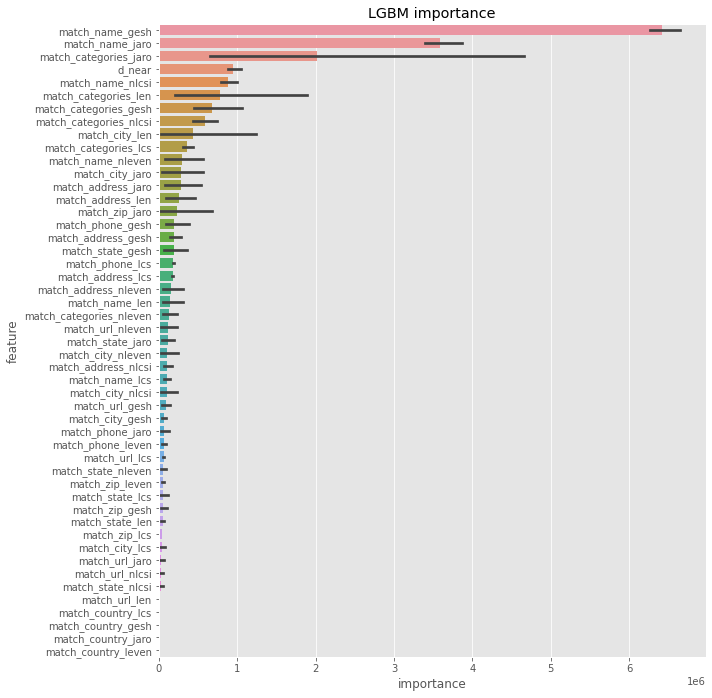

In [26]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

In [ ]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

train_candidate = postprocess(train_candidate)
#test = postprocess(test)
print(f"CV: {get_score(train_candidate):.6f}")

In [36]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

train_candidate = postprocess(train_candidate)
#test = postprocess(test)
print(f"CV: {get_score(train_candidate):.6f}")

100%|██████████| 1138812/1138812 [00:00<00:00, 1242367.40it/s]


CV: 0.808094


In [37]:
train_candidate

,id,matches,candidates
0,E_000001272c6c5d,E_000001272c6c5d E_da7fa3963561f8,E_da7fa3963561f8
1,E_000002eae2a589,E_000002eae2a589 E_e80db432029aea,E_e80db432029aea
2,E_000007f24ebc95,E_000007f24ebc95,NaN
3,E_000008a8ba4f48,E_000008a8ba4f48,NaN
4,E_00001d92066153,E_00001d92066153 E_7e0d8e9138dd56 E_53fd499abc...,E_7e0d8e9138dd56 E_53fd499abcdb8c E_ce81322e97...
...,...,...,...
1138807,E_ffffb80854f713,E_ffffb80854f713 E_008558a7c44ed5,E_008558a7c44ed5
1138808,E_ffffbf9a83e0ba,E_ffffbf9a83e0ba E_37cbd58e31092a,E_37cbd58e31092a
1138809,E_ffffc572b4d35b,E_ffffc572b4d35b E_fa389570ea207b E_27bcc6f6dd...,E_fa389570ea207b E_27bcc6f6dd33ed E_8081185a21...
1138810,E_ffffca745329ed,E_ffffca745329ed E_04988888cfff60,E_04988888cfff60
